In [12]:
import tensorflow as tf 
import cv2 
import os 
from collections import Counter
import pandas
import sys
import io

In [3]:
rootDir = 'A:\Lip Reading\Potential Datasets\BBC LRS2\\allFiles'
vocab = [x for x in "ABCDEFGHIJKLMNOPQRSTUVWXYZ'?!123456789 "]

def getFrameAndSizeCount(path) -> int: 
    cap = cv2.VideoCapture(path)
    frameCount = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
    height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
    size = (width, height)
    cap.release()
    return frameCount, size
def getCharCount(path) -> int: 
    return len(loadText(path))
def numberToWords(num):  
    if num == 0:  
        return "zero"  
    ones = ["", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]  
    tens = ["", "", "twenty", "thirty", "forty", "fifty", "sixty", "seventy", "eighty", "ninety"]  
    teens = ["ten", "eleven", "twelve", "thirteen", "fourteen", "fifteen", "sixteen", "seventeen", "eighteen", "nineteen"]  
    words = ""  
    if num>= 1000:  
        words += ones[num // 1000] + " thousand "  
        num %= 1000  
    if num>= 100:  
        words += ones[num // 100] + " hundred "  
        num %= 100  
    if num>= 10 and num<= 19:  
        words += teens[num - 10] + " "  
        num = 0  
    elif num>= 20:  
        words += tens[num // 10] + " "  
        num %= 10  
    if num>= 1 and num<= 9:  
        words += ones[num] + " "  
    return words.strip().upper()
def loadText(path): 
    # open and parse the file 
    with open(path, 'r') as file: lines = file.readlines()
    file.close()
    
    # return the number equivalent of each of the characters of the word 
    tokens = []
    words = lines[0].split()
    del words[0]

    for word in words: 
        if word.isnumeric():
            newWord = numberToWords(int(word))
            words[words.index(word)] = newWord
    words = " ".join(words).split()
    
    for word in words: 
        tokens = [*tokens,' ', word]
    
    return charToNum(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]   
charToNum = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")

In [4]:
# finding the max number of frames & chars in a certain video 
randomDir = None
def dataStats(dir, progressNum, isDir=True): 
    global randomDir
    frameCt = []
    sizes = []
    charCt = []
    vidList = []
    textList = []
    counter = 0
    if isDir: 
        # iterating through each file in the root folder
        for subdir, dirs, files in os.walk(dir):
            for file in files:
                if file.split('.')[1] == "mp4": 
                    frameCount, size = getFrameAndSizeCount(os.path.join(subdir, file))
                    frameCt.append(frameCount)
                    sizes.append(size)
                    vidList.append(os.path.join(subdir, file))
                    randomDir = (os.path.join(subdir, file))
                if file.split('.')[1] == "txt": 
                    charCt.append(getCharCount(os.path.join(subdir, file)))
                    textList.append(os.path.join(subdir, file))
                counter += 1 
                if counter % progressNum == 0:
                    print(counter, "files done")
    if not isDir: 
        if dir.split('.')[1] == "mp4": 
            frameCount, size = getFrameAndSizeCount(os.path.join(subdir, file))
            frameCt.append(frameCount)
            sizes.append(size)
            vidList.append(os.path.join(subdir, file))
            randomDir = (os.path.join(subdir, file))
        if dir.split('.')[1] == "txt": 
            charCt.append(getCharCount(dir))
            textList.append(dir)
    return frameCt, sizes, charCt, vidList, textList    

In [15]:
def mostCommon(lst):
    return max(set(lst), key=lst.count)

def freq(lst):
    d = {}
    for i in lst:
        if d.get(i):
            d[i] += 1
        else:
            d[i] = 1
    return d

def printStats(frameCt, sizes, charCt, vidList, textList, percentUsed = 1): 
    frameRate = 25
    print("=" * 100)
    print("=" * 100)

    print("num videos:", len(frameCt))
    print("=" * 100)

    print("FRAME COUNT STATS", '\n')
    print("max frame count:", max(frameCt), ", index:", frameCt.index(max(frameCt)))
    print("longest video:", vidList[frameCt.index(max(frameCt))])
    print("min frame count:", min(frameCt), ", index:", frameCt.index(min(frameCt)))
    print("shortest video:", vidList[frameCt.index(min(frameCt))])
    print("frame count frequencies:", freq(frameCt))
    
    print("=" * 100)
    print("=" * 100)

    print("FRAME SIZE STATS", '\n')
    print("max frame sizes:", max(sizes), ", index:", sizes.index(max(sizes)))
    print("largest (frame size-wise) video:", vidList[sizes.index(max(sizes))])
    print("frame shape frequencies:", freq(sizes))

    print("=" * 100)
    print("=" * 100)

    print("CHAR COUNT STATS", '\n')
    print("max char count:", max(charCt), ", index:", charCt.index(max(charCt)))
    print("longest text:", textList[charCt.index(max(charCt))])
    print("min char count:", min(charCt), ", index:", charCt.index(min(charCt)))
    print("shortest text:", textList[charCt.index(min(charCt))])
    print("char count frequencies:", freq(charCt))
    
    
    print("=" * 100)
    print("=" * 100)    
    print("TOTAL CONTENT STATS", '\n')
    print("total num of frames:", sum(frameCt))
    print("total num of frames used :", int(sum(frameCt) * percentUsed))
    print("total hours of video:", (sum(frameCt) / frameRate / 3600))
    print("total hours of video used :", (sum(frameCt) / frameRate / 3600) * percentUsed)
    print("total minutes of video:", (sum(frameCt) / frameRate / 60))
    print("total minutes of video used :", (sum(frameCt) / frameRate / 60) * percentUsed)
    print("=" * 100)
    print("=" * 100)
    print("AVERAGE CONTENT STATS", '\n' )
    print("avg num of frames: ", int(sum(frameCt)/len(frameCt)))
    print("avg chars per vid:", int(sum(charCt)/len(charCt)))
    print("most common number of frames:", mostCommon(frameCt))
    print("most common number of characters:", mostCommon(charCt))
    print("=" * 100)
    print("=" * 100)

def visualizeDistribution(data, name=None):
    data = sorted(data)
    count = Counter(data)
    df = pandas.DataFrame.from_dict(count, orient='index')
    if name is None:
        df.plot(kind='bar',  legend=False)
    else: 
        df.plot(kind='bar',  legend=False, title=name)

def writeOutputToTXT(frameCt, sizes, charCt, vidList, textList, folderName, percentUsed = 1): 
    
    fileName = folderName + "_" + str(percentUsed) + ".txt"
    file = open(fileName, 'w')
    file.write(folderName + "====" + percentUsed * 100 + "% used" + "\n")
    
    file.close()
    
    sys.stdout = open(fileName, 'w')
    
    printStats(frameCt, sizes, charCt, vidList, textList)
    
    sys.stdout.close()
        

In [ ]:
frameCt, sizes, charCt, vidList, textList = dataStats("A:\Lip Reading\Potential Datasets\BBC LRS2\\trainFiles1", progressNum=500)

In [10]:
printStats(frameCt, sizes, charCt, vidList, textList)

num videos: 1139
FRAME COUNT STATS 

max frame count: 154.0 , index: 300
longest video: A:\Lip Reading\Potential Datasets\BBC LRS2\trainFiles1\5954641443877070848_00015.mp4
min frame count: 14.0 , index: 923
shortest video: A:\Lip Reading\Potential Datasets\BBC LRS2\trainFiles1\6225108419408161933_00037.mp4
frame count frequencies: {71.0: 13, 43.0: 30, 41.0: 20, 59.0: 11, 109.0: 2, 92.0: 8, 75.0: 6, 38.0: 16, 107.0: 2, 42.0: 18, 149.0: 2, 97.0: 5, 33.0: 28, 138.0: 2, 28.0: 31, 63.0: 17, 52.0: 13, 66.0: 12, 65.0: 9, 32.0: 22, 35.0: 29, 46.0: 29, 44.0: 22, 53.0: 15, 27.0: 20, 84.0: 7, 60.0: 11, 40.0: 27, 36.0: 24, 51.0: 25, 54.0: 22, 87.0: 4, 30.0: 28, 26.0: 19, 117.0: 1, 82.0: 4, 47.0: 14, 29.0: 26, 101.0: 5, 68.0: 10, 45.0: 30, 72.0: 7, 48.0: 9, 130.0: 6, 114.0: 6, 24.0: 18, 70.0: 6, 98.0: 4, 55.0: 13, 37.0: 20, 22.0: 16, 18.0: 2, 110.0: 4, 80.0: 9, 67.0: 7, 25.0: 27, 31.0: 19, 147.0: 1, 73.0: 8, 62.0: 15, 61.0: 12, 50.0: 14, 90.0: 7, 19.0: 1, 116.0: 3, 81.0: 3, 21.0: 12, 125.0: 1, 88.

In [14]:
writeOutputToTXT(frameCt, sizes, charCt, vidList, textList, folderName="trainFiles1", percentUsed = 1) 

TypeError: can only concatenate str (not "int") to str

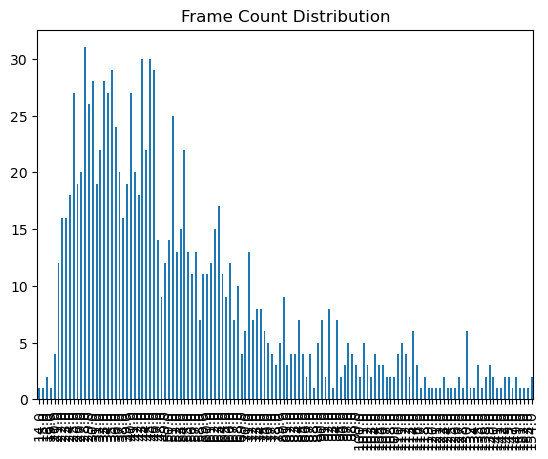

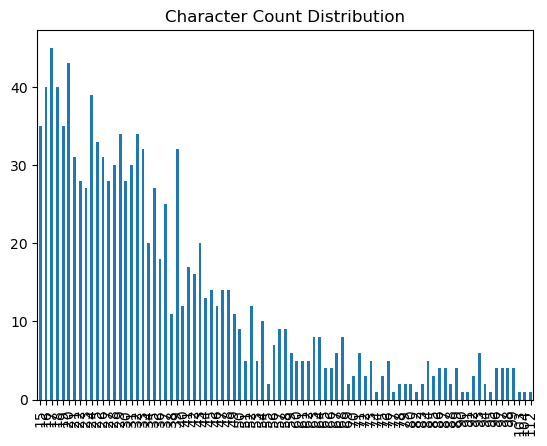

In [11]:
visualizeDistribution(frameCt,"Frame Count Distribution")
visualizeDistribution(charCt, "Character Count Distribution" )

In [45]:
(getFrameCount("A:\v\Lip Reading\\Potential Datasets\\BBC LRS2\\trainFiles\\5536745420943636139_00027.mp4"))

115.0

In [38]:
cap = cv2.VideoCapture(randomDir)
frameCount = cap.get(cv2.CAP_PROP_FRAME_COUNT)
cap.release()
print(frameCount)

0.0


In [44]:
randomDir 

'A:\\Lip Reading\\Potential Datasets\\BBC LRS2\\trainFiles\\6383993433079191521_00008.mp4'

In [142]:
newDir = "A:\Lip Reading\Potential Datasets\BBC LRS2\\trainFiles2" 
for subdir, dirs, files in os.walk(newDir):
    for file in files: 
        if file.split('.')[1] == "mp4": 
            if os.path.isfile(os.path.join(subdir, file.split('.')[0] + ".txt")): 
                # print("works")
                pass
            else: 
                print(file)
            
        if file.split('.')[1] == "txt": 
            if os.path.isfile(os.path.join(subdir, file.split('.')[0] + ".mp4")): 
                pass
            else: 
                print(file)
